In [2]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score


Parte 1: Carga y Exploración Inicial de Datos

- Carga del Dataset:
    * Cargar el dataset desde Kaggle.
- Exploración Inicial:
    * Revisar la estructura del dataset.
    * Describir las variables y su distribución.
    * Identificar y documentar valores faltantes y outliers.


In [ ]:
##Cargar los datos
ruta_archivo = '../ejercicios_core/data/heart.csv'

df = utils.cargar_datos(ruta_archivo)

df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [4]:
utils.exploracion_inicial(df)

Informacion del dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140

Este dataset cuenta con 1025 filas y 14 columnas, las cuales con la primera verificacion no cuenta con elementos nulos. Todas las columnas son de valores numericos debido a que las variables categoricas ya fueron modificadas previamente.

In [5]:
na_df = utils.identificar_valores_faltantes(df)
print(na_df)
utils.verificacion_elementos_duplicados(df)

Valores faltantes en el dataset
          datos sin NAs en q  Na en q  Na en %
age                     1025        0      0.0
sex                     1025        0      0.0
cp                      1025        0      0.0
trestbps                1025        0      0.0
chol                    1025        0      0.0
fbs                     1025        0      0.0
restecg                 1025        0      0.0
thalach                 1025        0      0.0
exang                   1025        0      0.0
oldpeak                 1025        0      0.0
slope                   1025        0      0.0
ca                      1025        0      0.0
thal                    1025        0      0.0
target                  1025        0      0.0
Cantidad de filas duplicadas:  723


No se detectan valores faltantes, sin embargo se encuentran 723 valores duplicados los cuales debido a que son un numero bastante grande 723 no lo procederemos a eliminar. Esto podria deberse a que el dataset fue previamente limpiado pero verificaremos las cantidades de clases para ver si no existen sesgos que podrian corregirse eliminando estos valores.

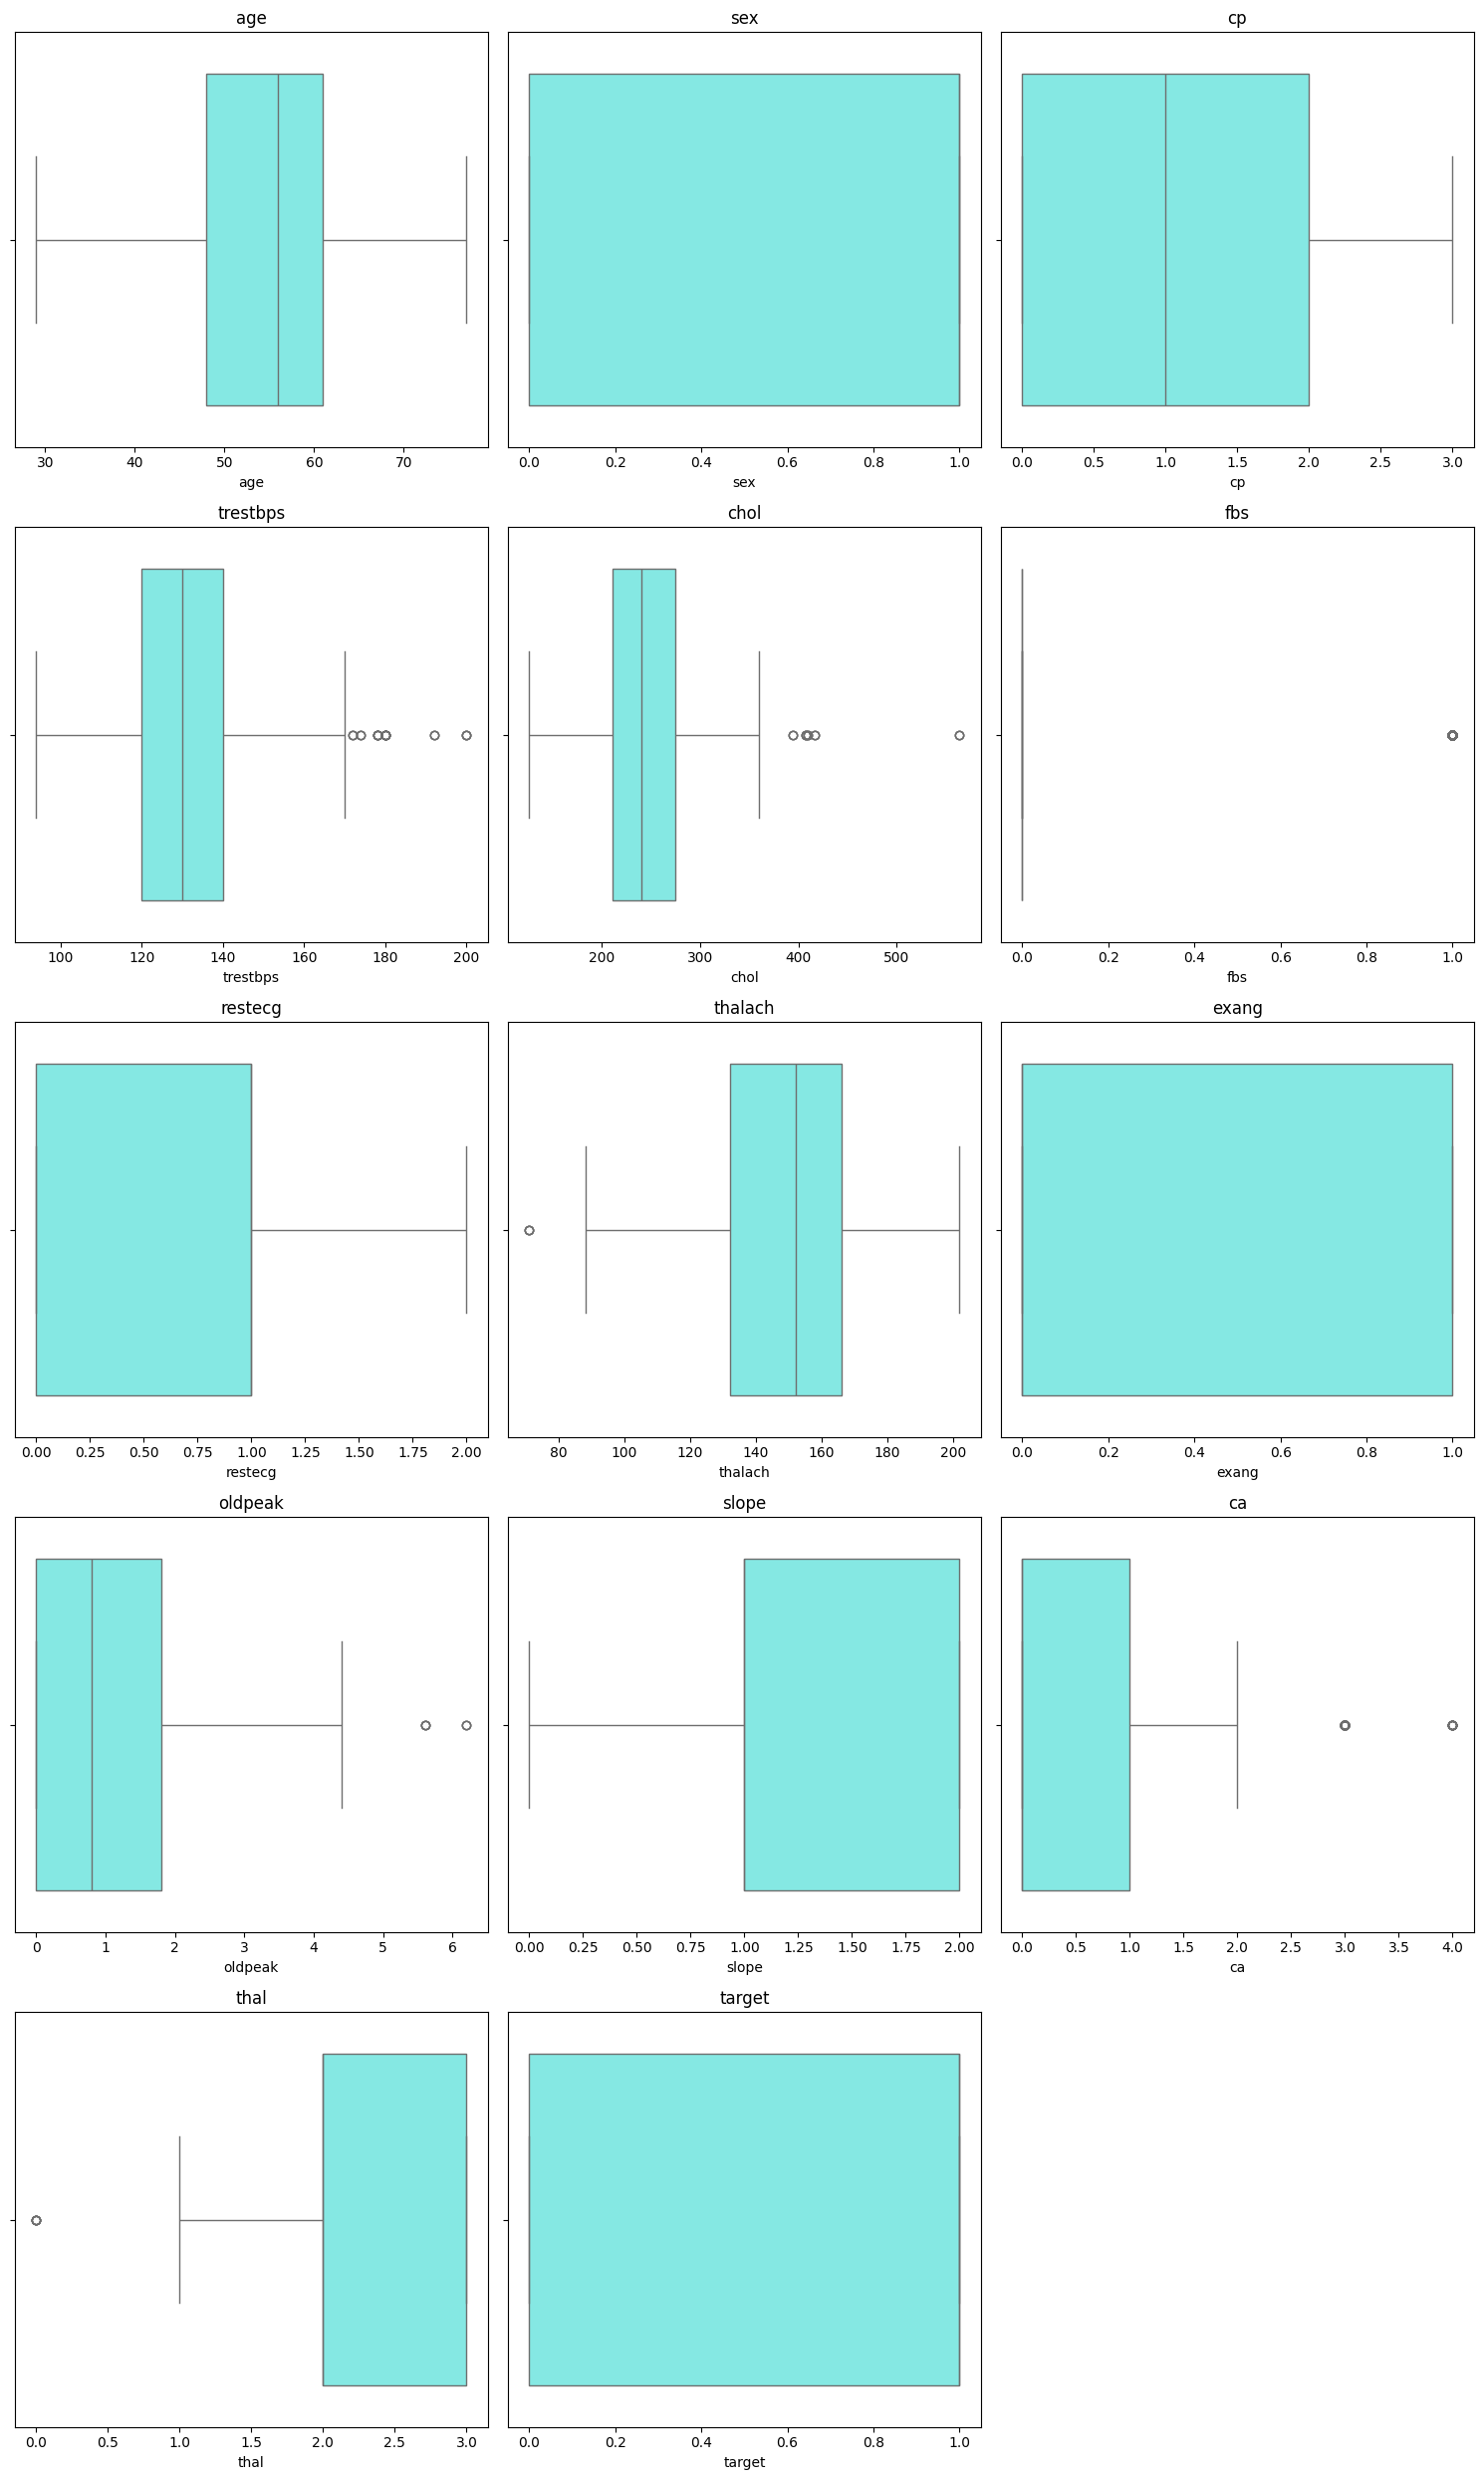

In [6]:
numeric_values = df.select_dtypes(include=['float64', 'int64'])
utils.plot_grafico_outliers(numeric_values,5,3,df)

El grafico muestra las siguientes caracteristicas:
* Variables como age, trestbps, chol, y thalach parecen ser numéricas y tienen valores en rangos definidos.
* Otras variables (sex, cp, fbs, restecg, exang, slope, ca, thal, target) parecen ser categóricas o binarias, ya que tienen un número limitado de valores únicos.

Se visualizan variables outliers en  chol, thalach, oldpeak, ca y thal. Estos son posibles valores atípicos que podrían requerir análisis adicional.

Parte 2: Análisis Exploratorio de Datos (EDA)

- Análisis Estadístico Descriptivo:
    * Calcular estadísticas descriptivas básicas (media, mediana, desviación estándar, etc.).
    * Analizar la distribución de las variables categóricas.
- Visualizaciones:
    * Crear histogramas y gráficos de barras para entender la distribución de las variables.
    * Crear un mapa de calor para visualizar las correlaciones entre las variables.
    * Utilizar gráficos de dispersión para identificar posibles relaciones entre las variables.
- Valores Faltantes y Outliers:
    * Detectar y tratar valores faltantes.
    * Identificar y manejar outliers.


In [7]:
utils.estadisticas_descriptivas(df)

Estadisticas del dataset
               age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.00000   
std       9.072290     0.460373     1.029641    17.516718    51.59251   
min      29.000000     0.000000     0.000000    94.000000   126.00000   
25%      48.000000     0.000000     0.000000   120.000000   211.00000   
50%      56.000000     1.000000     1.000000   130.000000   240.00000   
75%      61.000000     1.000000     2.000000   140.000000   275.00000   
max      77.000000     1.000000     3.000000   200.000000   564.00000   

               fbs      restecg      thalach        exang      oldpeak  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.000000   
mean      0.149268     0.529756   149.114146     0.336585     1.071512   
std       0.356527     0.527878    23.005724     0.472772     1.175053   
min       0.000000   

En términos generales, el dataset parece tener una buena distribución en cuanto a las características, con algunos valores extremos (como el colesterol). Las estadísticas de dispersión también indican que algunas variables, como el colesterol, la frecuencia cardíaca máxima y el dolor en el pecho, tienen una considerable variabilidad.

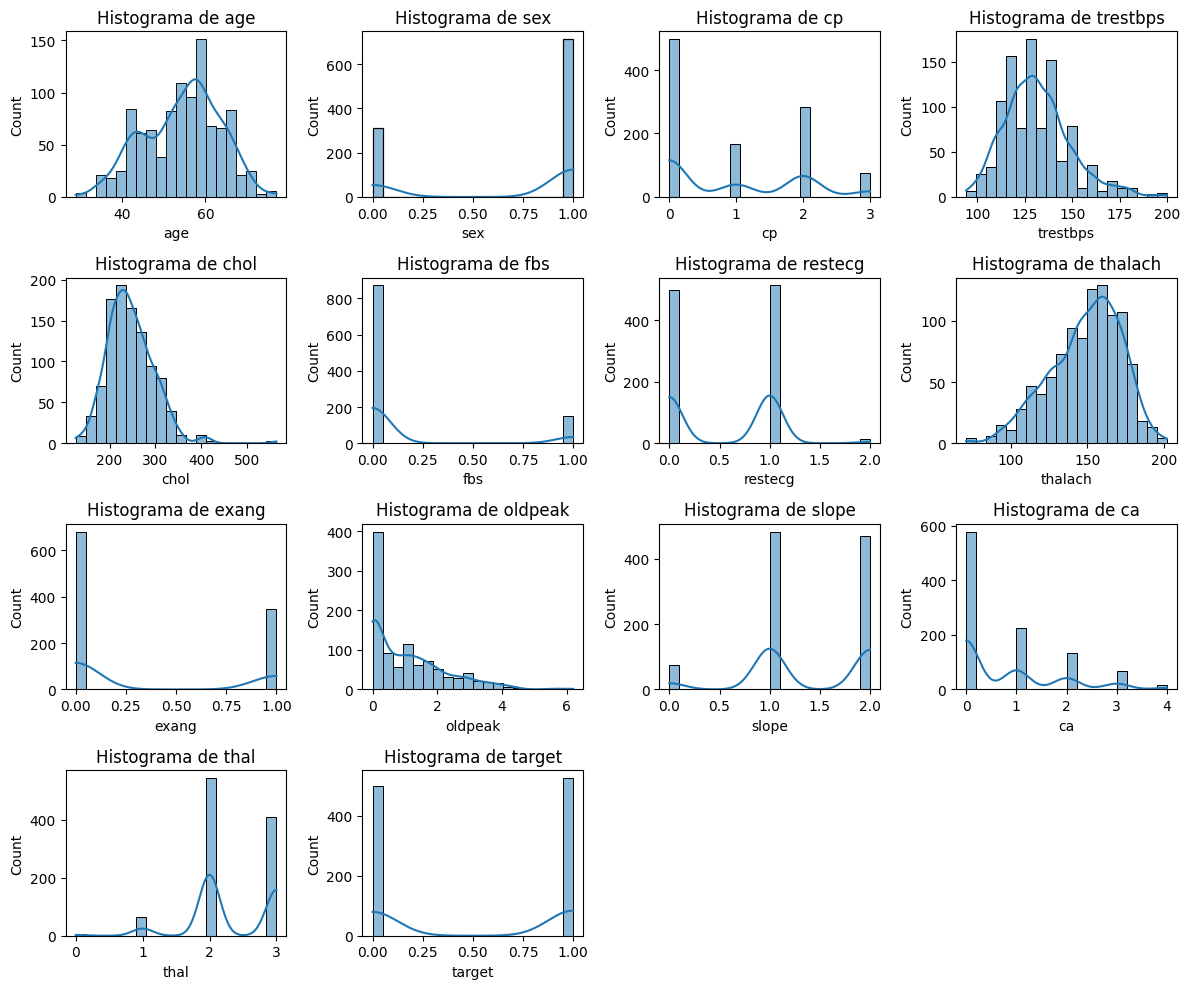

In [8]:
# Crear histogramas para cada variable numérica
# Crear histogramas para cada variable numérica
plt.figure(figsize=(12, 10))
for i, column in enumerate(numeric_values, 1):
    plt.subplot(4, 4, i)  # Ajusta el número de filas y columnas según el número de variables
    sns.histplot(df[column], kde=True, bins=20)
    plt.title(f"Histograma de {column}")
    plt.tight_layout()

plt.show()



En resumen, las distribuciones varían entre normales, sesgadas y distribuciones discretas para variables categóricas. Algunos valores están muy concentrados en ciertos rangos, mientras que otros muestran una mayor dispersión. Si nos posicionamos en el target podemos ver que estan relativamente balanceados con un pequeño margen mayor en el 1.

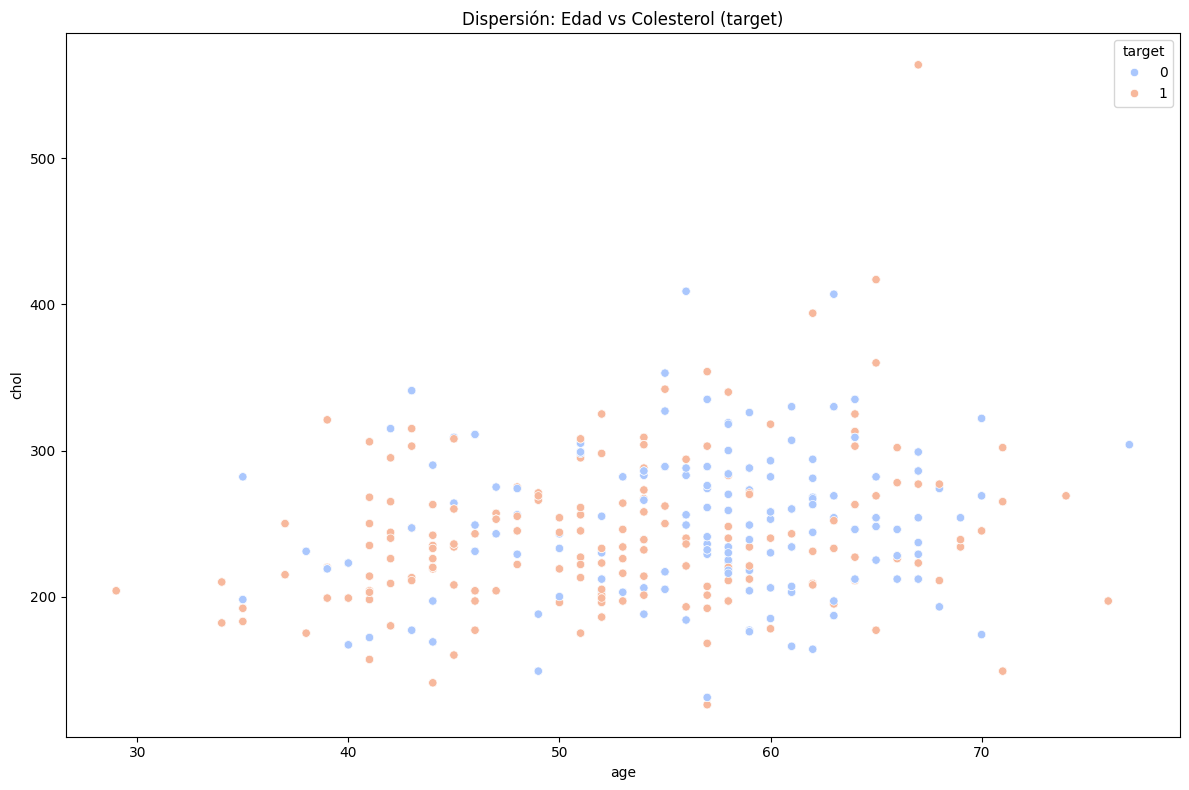

In [9]:
# Gráficos de dispersión entre las variables más relevantes
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df['age'], y=df['chol'], hue=df['target'], palette='coolwarm')
plt.title('Dispersión: Edad vs Colesterol (target)')
plt.tight_layout()
plt.show()

El gráfico sugiere que los pacientes con enfermedad cardíaca (target = 1) tienden a tener niveles más altos de colesterol y generalmente también son de mayor edad. Esto puede ser un indicio de que tanto la edad como los niveles altos de colesterol son factores importantes asociados con la presencia de enfermedad cardiovascular en este dataset. Sin embargo, también hay muchos casos con colesterol alto que no tienen enfermedad cardíaca, lo que indica que hay otros factores que influyen en el diagnóstico.

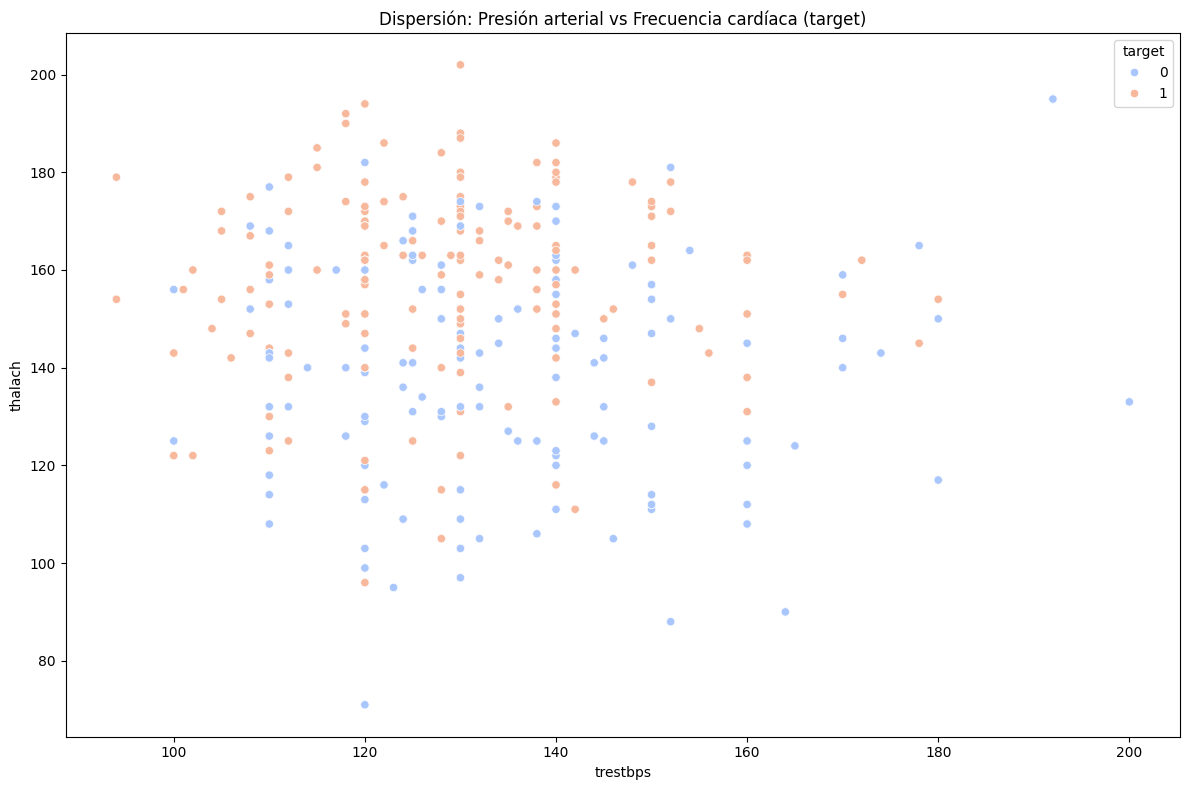

In [10]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df['trestbps'], y=df['thalach'], hue=df['target'], palette='coolwarm')
plt.title('Dispersión: Presión arterial vs Frecuencia cardíaca (target)')
plt.tight_layout()
plt.show()

Lo que se puede observar en este grafico es que no hay una correlacion lineal clara entre estas dos variables. La dispersion de los datos indica a que otras variables ademas de estas dos influyen en la presencia o no de enfermedades cardiacas.

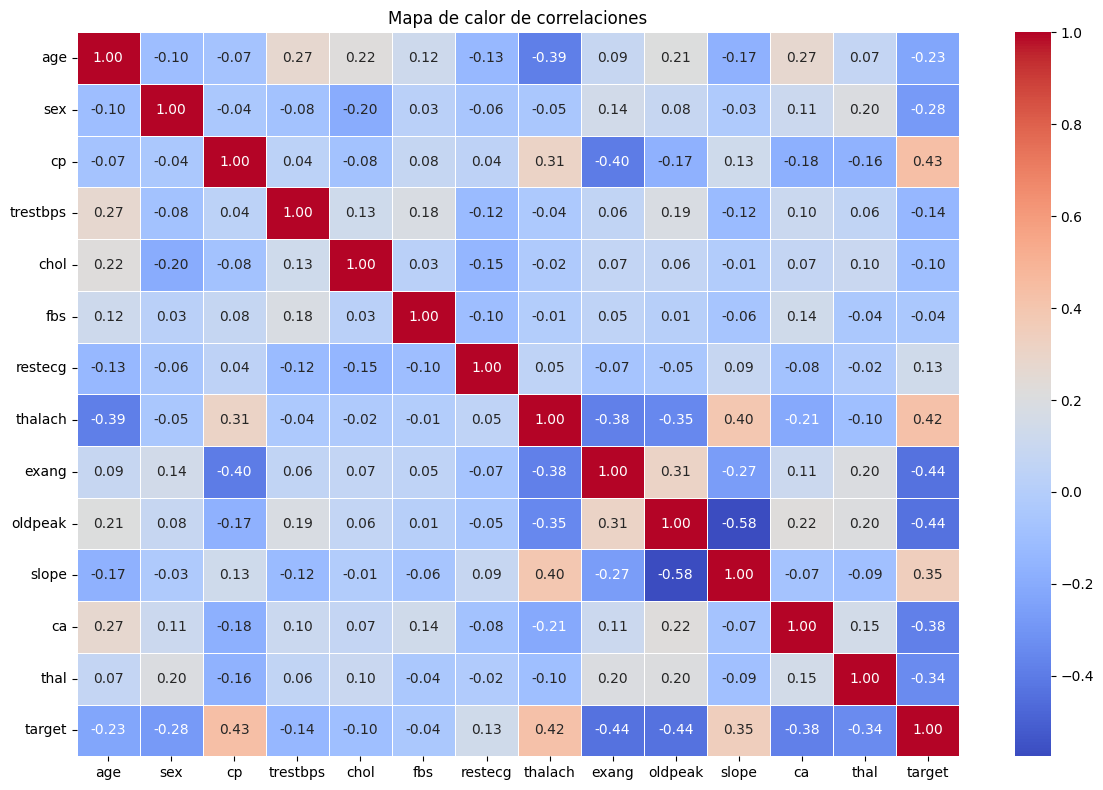

In [11]:
# Mapa de calor de correlación
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()  # Calcula la correlación entre las variables numéricas
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de calor de correlaciones')
plt.tight_layout()
plt.show()

En este grafico se puede ver que el target tiene fuerte relacion con CP, thalach, slope con 0.43, 0.42, 0.35.

Parte 3: Preprocesamiento de Datos

- Transformación de Columnas:
    * Codificar variables categóricas utilizando One-Hot Encoding.
    * Escalar características numéricas utilizando StandardScaler.
- División del Conjunto de Datos:
    * Dividir el dataset en conjuntos de entrenamiento y prueba.


In [12]:
# Definir X e y. Dividir los datos en conjunto de entrenamiento y prueba

X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [13]:
## Ya se han tratado los valores nulos pero aun existen valores outliers que seran escalados con RobustScaler
###Pipeline para preprocesamiento de valores
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  # Get column names
# Crear transformadores para cada subconjunto de columnas
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

# Combinar transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ]
)

# Integrar en un pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Crear y aplicar el pipeline a los datos de entrenamiento
X_train_transformed = pipeline.fit_transform(X_train)

# Aplicar la misma transformación a los datos de prueba (sin hacer fit)
X_test_transformed = pipeline.transform(X_test)

print("Preprocesamiento completado. Datos transformados listos para modelar.")

Preprocesamiento completado. Datos transformados listos para modelar.


Parte 4: Implementación de XGBoost

- Entrenamiento del Modelo:
    * Entrenar un modelo de XGBoost con hiperparámetros básicos.
    * Evaluar el modelo utilizando métricas de rendimiento como la exactitud, precisión, recall, F1-Score y ROC-AUC.
- Optimización de Hiperparámetros:
    * Utilizar GridSearchCV para optimizar los hiperparámetros del modelo de XGBoost.
- Evaluación del Modelo Optimizado:
    * Evaluar el rendimiento del modelo optimizado y compararlo con el modelo inicial.


Exactitud: 1.0
Informe de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       1.00      1.00      1.00       107

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205

Matriz de Confusión:
[[ 98   0]
 [  0 107]]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:47:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


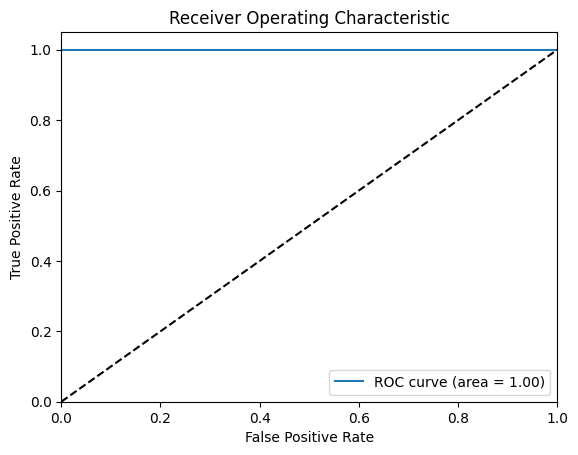

In [14]:
# Crear el modelo XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

#Explicación de los Hiperparámetros

    #use_label_encoder: Desactiva el uso del codificador de etiquetas incorporado en versiones recientes de XGBoost.
    #eval_metric: Métrica utilizada para la evaluación durante el entrenamiento. logloss es común para problemas de clasificación.
    #random_state: Semilla utilizada por el generador de números aleatorios para asegurar la reproducibilidad de los resultados.


# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Exactitud: {accuracy}')
print('Informe de Clasificación:')
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(conf_matrix)

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
##Como el modelo tiene un accuracy de 1 y el ROC tambien presenta este resultado,
#procederemos a modificar el modelo a traves de gridsearch para no tener overfitting
# Definir el espacio de hiperparámetros
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'alpha': [0, 0.1, 0.5],
    'lambda': [0, 0.1, 1.0],
    'gamma': [0, 0.1, 0.5],
    'min_child_weight': [1, 5, 10],
    'colsample_bytree': [0.7, 0.8, 1.0]
}


# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Ejecutar GridSearchCV
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Exactitud del mejor modelo: {accuracy}')
print('Informe de Clasificación:')
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(conf_matrix)

Mejores hiperparámetros encontrados:
{'alpha': 0, 'colsample_bytree': 0.7, 'gamma': 0, 'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Exactitud del mejor modelo: 1.0
Informe de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       1.00      1.00      1.00       107

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205

Matriz de Confusión:
[[ 98   0]
 [  0 107]]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:13:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
